In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from datetime import timedelta

p = sns.color_palette()

import sys
sys.path.append("..") # Adds higher directory to python modules path.

from utils import *

In [2]:
df = pd.read_csv('g-search/data/train.csv', index_col=0)
df_test = pd.read_csv('g-search/data/test.csv', index_col=0)
print('Number of rows: {}, Number of columns: {}'.format(*df.shape))

Number of rows: 623817, Number of columns: 16


In [3]:
df.head()

,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,x3E,x4,x5,x6,y,Weight
Index,,,,,,,,,,,,,,,,
0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,2.180516e-05,4.416943e-05,0.002212,6.214737e-07,200.000000,-0.000196,1.533780
1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,4.193762e-05,4.193762e-05,0.010932,3.414868e-05,300.000000,-0.003798,0.843604
2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,1.080834e-06,2.030442e-06,0.000306,4.079460e-08,159.692076,-0.000003,29.824024
3,1,1,1942,0.045300,0.608222,0.456662,1.928694e-08,6.495275e-08,1.338509e-07,2.644214e-07,6.980798e-07,0.000205,9.502066e-09,212.160378,-0.000008,100.388668
4,1,1,2712,0.001605,0.476718,0.205069,6.759866e-07,2.638783e-06,6.424519e-06,1.189923e-05,2.064450e-05,0.001525,3.428403e-07,153.724351,0.000065,5.950714


In [4]:
df['Date'] = pd.to_datetime("'2015-10-01'") # assumption
df['Date'] = df['Date'] + df['Day'].map(timedelta) - timedelta(days=1)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.weekofyear
df['Weekday'] = df['Date'].dt.weekday
df['DayMonth'] = df['Date'].dt.day

In [5]:
df.isnull().sum()

Market       0
Day          0
Stock        0
x0           0
x1          55
x2           5
x3A          0
x3B          0
x3C          0
x3D          0
x3E          0
x4           0
x5           0
x6           0
y            0
Weight       0
Date         0
Year         0
Month        0
Week         0
Weekday      0
DayMonth     0
dtype: int64

In [6]:
def fillna_bystock(df):
    for c in df.columns:
        df[c] = df.groupby(['Stock'])[c].apply(lambda x: x.fillna(method="ffill").fillna(method="backfill").fillna(0))
    return df

In [7]:
# Fill NaNs values by stock
df = fillna_bystock(df)
df.isnull().sum()

Market      0
Day         0
Stock       0
x0          0
x1          0
x2          0
x3A         0
x3B         0
x3C         0
x3D         0
x3E         0
x4          0
x5          0
x6          0
y           0
Weight      0
Date        0
Year        0
Month       0
Week        0
Weekday     0
DayMonth    0
dtype: int64

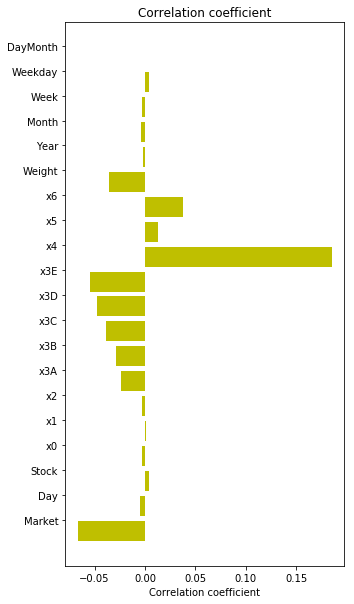

In [8]:
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['id','Date','y']]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.y.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(5,10))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()

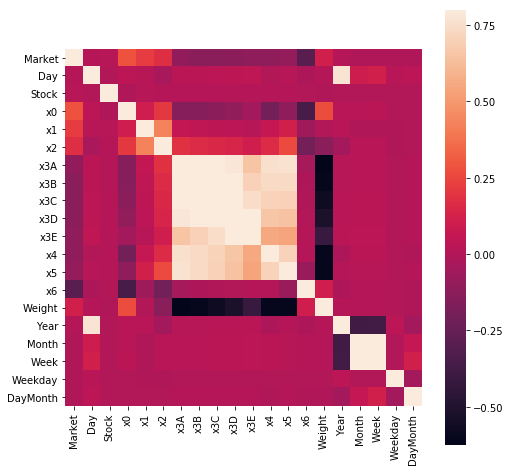

In [9]:
corrmat = df[x_cols].corr(method='kendall')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

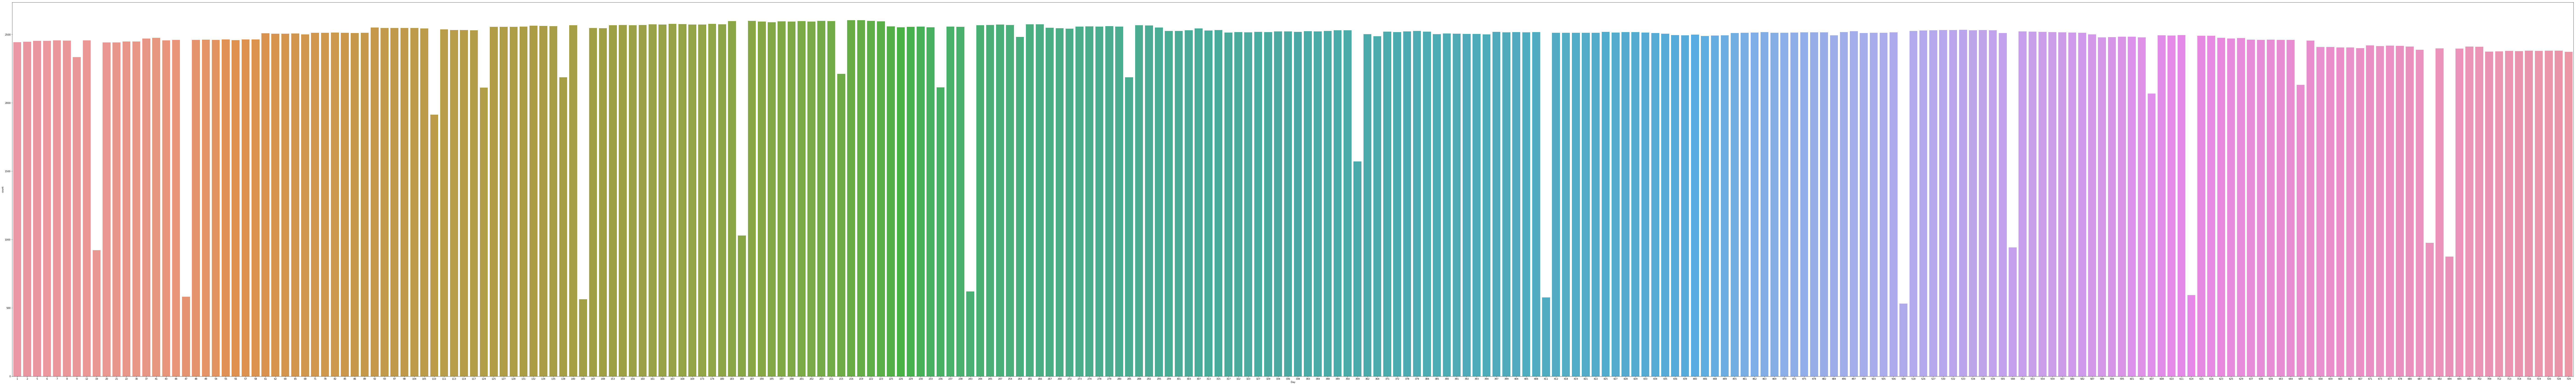

In [12]:
fig = plt.figure(figsize=(200, 30))
sns.countplot(x='Day', data=df)
plt.show()

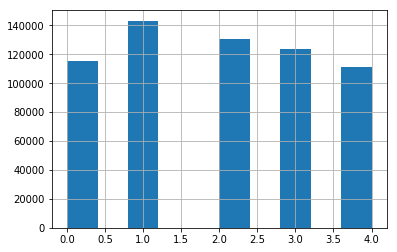

In [13]:
df['Weekday'].hist()

In [17]:
print('Target y: oscillate between  {} and {}'.format(df.y.min(), df.y.max()))

Target y: oscillate between  -0.071098947020338 and 0.06661666666792901


Target value min -0.071 max 0.067 mean 0.000 std 0.001


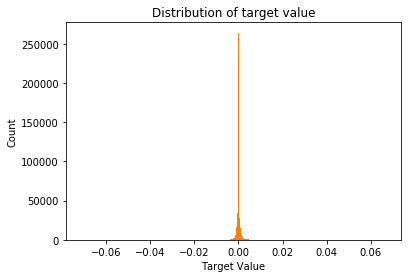

In [18]:
y = df['y'].values
plt.hist(y, bins=500, color=p[1])
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of target value')
print('Target value min {0:.3f} max {1:.3f} mean {2:.3f} std {3:.3f}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

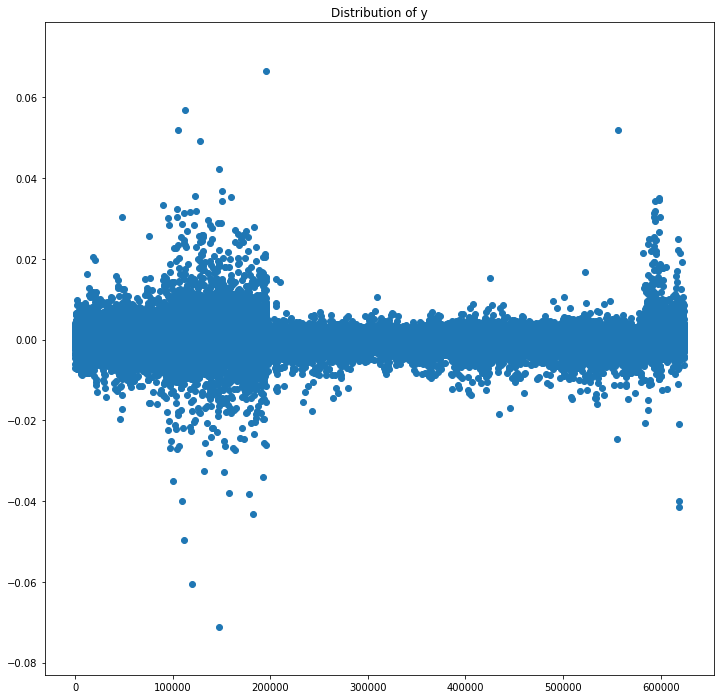

In [19]:
plt.figure(figsize=(12, 12))
plt.scatter(range(df.shape[0]), df.y.values)
plt.title("Distribution of y")
plt.show()

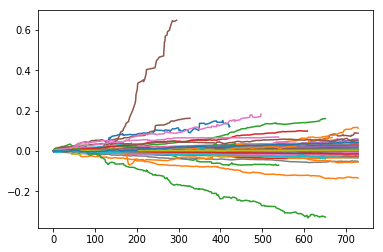

In [21]:
for i, (idVal, dfG) in enumerate(df[['Stock', 'Day', 'y']].groupby('Stock')):
    if i > 100: continue
    df1 = dfG[['Day', 'y']].groupby('Day').agg(np.mean).reset_index()
    plt.plot(df1['Day'], np.cumsum(df1['y']),label='%d'%idVal)

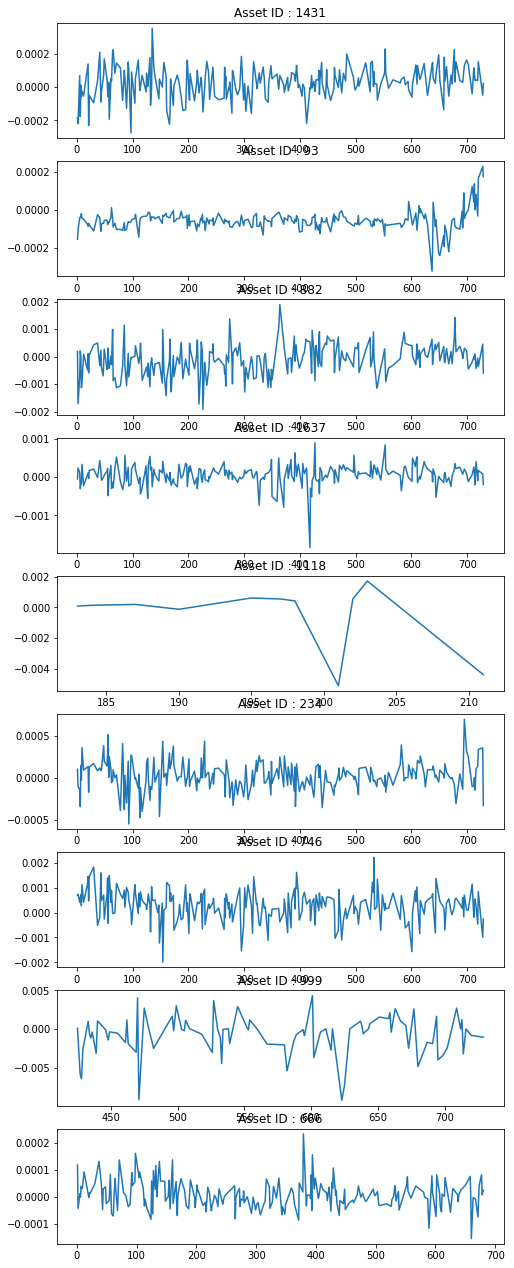

In [22]:
# Example of y values to some stocks
id_to_use = [1431, 93, 882, 1637, 1118, 234, 746, 999, 666]
fig = plt.figure(figsize=(8, 25))
plot_count = 0
for id_val in id_to_use:
    plot_count += 1
    plt.subplot(10, 1, plot_count)
    temp_df = df[df['Stock'] == id_val]
    plt.plot(temp_df.Day.values, temp_df.y.values)
    plt.title("Asset ID : "+str(id_val))
plt.show()

Target value min 0.003 max 694.002 mean 14.723 std 24.391


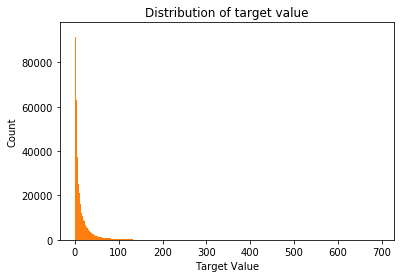

In [23]:
y = df['Weight'].values
plt.hist(y, bins=500, color=p[1])
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of target value')
print('Target value min {0:.3f} max {1:.3f} mean {2:.3f} std {3:.3f}'.format(np.min(y), np.max(y), np.mean(y), np.std(y)))

In [24]:
df.head()

,Market,Day,Stock,x0,x1,x2,x3A,x3B,x3C,x3D,...,x5,x6,y,Weight,Date,Year,Month,Week,Weekday,DayMonth
Index,,,,,,,,,,,,,,,,,,,,,
0,1,1,363,0.002696,0.530040,0.400810,1.300048e-06,4.639533e-06,1.073594e-05,2.180516e-05,...,6.214737e-07,200.000000,-0.000196,1.533780,2015-10-01,2015,10,40,3,1
1,1,1,1223,0.081093,1.366218,1.325157,1.656861e-05,3.024668e-05,5.261872e-05,4.193762e-05,...,3.414868e-05,300.000000,-0.003798,0.843604,2015-10-01,2015,10,40,3,1
2,1,1,1372,0.009561,0.464871,0.328008,6.500872e-08,2.323204e-07,5.182686e-07,1.080834e-06,...,4.079460e-08,159.692076,-0.000003,29.824024,2015-10-01,2015,10,40,3,1
3,1,1,1942,0.045300,0.608222,0.456662,1.928694e-08,6.495275e-08,1.338509e-07,2.644214e-07,...,9.502066e-09,212.160378,-0.000008,100.388668,2015-10-01,2015,10,40,3,1
4,1,1,2712,0.001605,0.476718,0.205069,6.759866e-07,2.638783e-06,6.424519e-06,1.189923e-05,...,3.428403e-07,153.724351,0.000065,5.950714,2015-10-01,2015,10,40,3,1


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


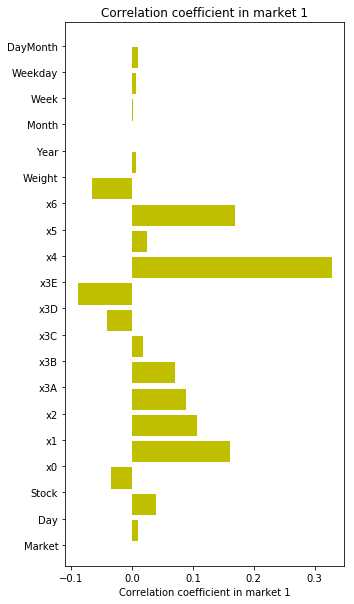

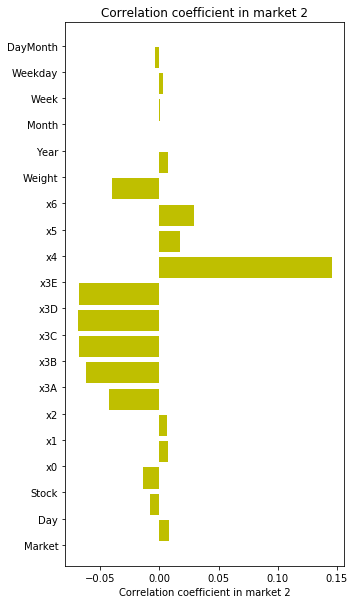

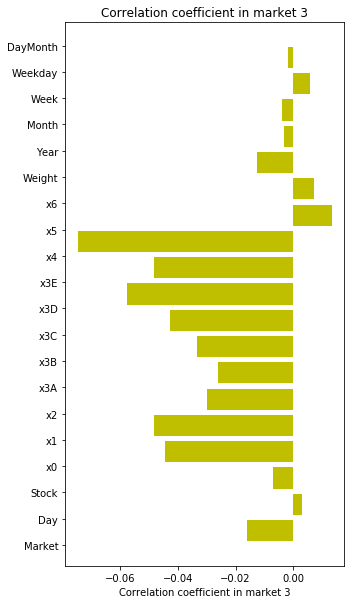

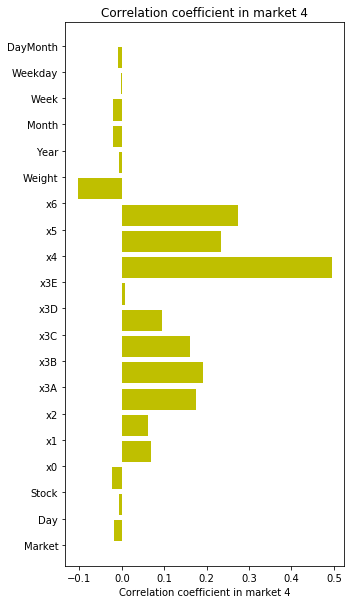

In [25]:
for idx in [1,2,3,4]:
    df_temp = df[df['Market'] == idx]

    # Now let us look at the correlation coefficient of each of these variables
    x_cols = [col for col in df.columns if col not in ['id','Date','y']]

    labels = []
    values = []
    for col in x_cols:
        labels.append(col)
        values.append(np.corrcoef(df_temp[col].values, df_temp.y.values)[0,1])

    ind = np.arange(len(labels))
    width = 0.9
    fig, ax = plt.subplots(figsize=(5,10))
    rects = ax.barh(ind, np.array(values), color='y')
    ax.set_yticks(ind+((width)/2.))
    ax.set_yticklabels(labels, rotation='horizontal')
    ax.set_xlabel("Correlation coefficient in market " + str(idx))
    ax.set_title("Correlation coefficient in market " + str(idx))
    plt.show()

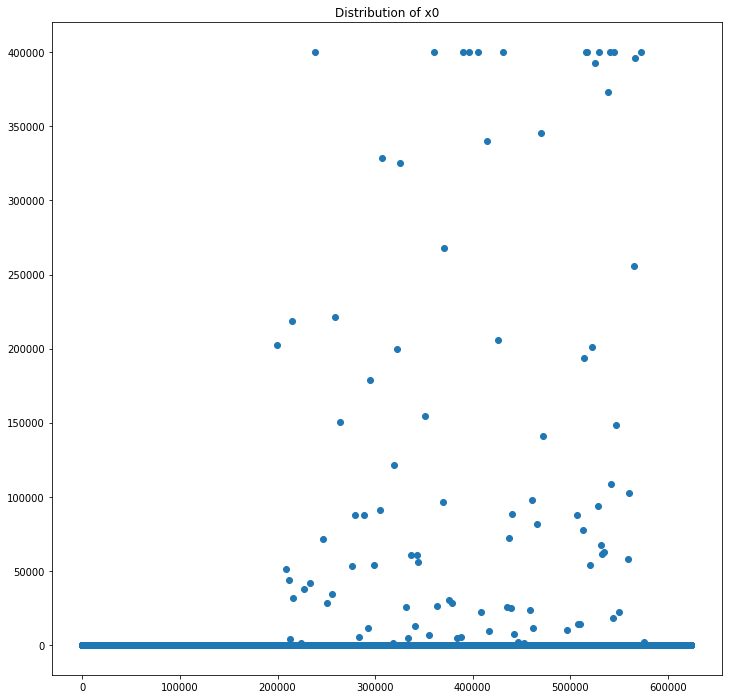

In [26]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(range(df.shape[0]), df['x0'].clip(0, 400000).values)
plt.title("Distribution of x0")
plt.show()

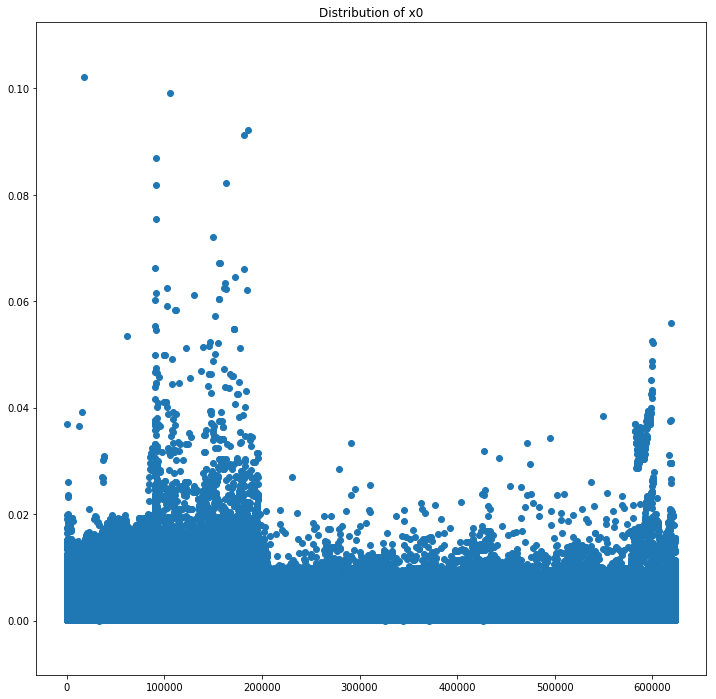

In [27]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(range(df.shape[0]), df['x4'].values)
plt.title("Distribution of x4")
plt.show()